In [1]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL, PNDMScheduler, DDPMScheduler
from transformers import T5EncoderModel, T5TokenizerFast
import torch
import os
import numpy as np
import librosa
from tqdm import tqdm
import soundfile as sf
import torchaudio
from IPython.display import Audio
import matplotlib.pyplot as plt
import json

In [9]:
torch_device = torch.device("cuda:0")
model_path = "/blob/v-yuancwang/AudioEditingModel/Diffusion_SG/checkpoint-350000"
checkpoint=68000
unet_path = "/blob/v-yuancwang/AUDITPLUS/AUDIT_CD_100/checkpoint-{}".format(str(checkpoint))
save_path = "/blob/v-yuancwang/AUDITDATA/AUDIT_CD_INFER"
# save_path = os.path.join(save_path, "infer_step_{}_gs_{}_cp_{}".format(str(num_inference_steps), str(guidance_scale), str(checkpoint)), "mel")
# os.makedirs(save_path, exist_ok=True)

In [ ]:
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(unet_path)
tokenizer = T5TokenizerFast.from_pretrained(model_path, subfolder="tokenizer")
text_encoder = T5EncoderModel.from_pretrained(model_path, subfolder="text_encoder")

vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)
vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder.requires_grad_(False)

In [17]:
num_inference_steps = 2
guidance_scale = 1

In [44]:
text = "A whistling and then an explosion and crackling"
prompt = [text]
text_input = tokenizer(prompt, max_length=tokenizer.model_max_length, truncation=True, padding="do_not_pad", return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * 1, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
print(text_embeddings.shape)
print(uncond_embeddings.shape)
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

torch.Size([1, 12, 768])
torch.Size([1, 12, 768])


In [45]:
scheduler = DDPMScheduler.from_pretrained(model_path, subfolder="scheduler")

In [46]:
noisy_latents = torch.randn((1, 4, 10, 78)).to(torch_device)
nosiy_latents_input = torch.cat([noisy_latents] * 2)

with torch.no_grad():
    timesteps = torch.tensor(990).to(torch_device)
    c_skip = 0.25 / (0.25 + (timesteps / 1000 - 0.0) ** 2)
    c_out = 0.5 * (timesteps / 1000 - 0.0) / ((timesteps / 1000) ** 2 + 0.25) ** 0.5
    pred_target = c_skip.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) * nosiy_latents_input + c_out.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) * unet(nosiy_latents_input, timesteps, text_embeddings).sample
    
    pred_target_uncond, pred_target_cond = pred_target.chunk(2)
    pred_target = pred_target_uncond + guidance_scale * (pred_target_cond - pred_target_uncond)

    if num_inference_steps == 2:

        z = torch.randn((1, 4, 10, 78)).to(torch_device)
        noisy_latents = scheduler.add_noise(pred_target, z, torch.tensor(500).to(torch_device))

        nosiy_latents_input = torch.cat([noisy_latents] * 2)

        with torch.no_grad():
            timesteps = torch.tensor(990).to(torch_device)
            c_skip = 0.25 / (0.25 + (timesteps / 1000 - 0.0) ** 2)
            c_out = 0.5 * (timesteps / 1000 - 0.0) / ((timesteps / 1000) ** 2 + 0.25) ** 0.5
            pred_target = c_skip.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) * nosiy_latents_input + c_out.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) * unet(nosiy_latents_input, timesteps, text_embeddings).sample
            
            pred_target_uncond, pred_target_cond = pred_target.chunk(2)
            pred_target = pred_target_uncond + guidance_scale * (pred_target_cond - pred_target_uncond)


In [47]:
latents_out = pred_target
with torch.no_grad():
    res = vae.decode(latents_out).sample
res = res.cpu().numpy()[0,0,:,:]
np.save(os.path.join("/home/v-yuancwang/AUDIT_v2/como/test_mel",
                     text+"_gs_"+str(guidance_scale)+"_step_"+str(num_inference_steps)), res)

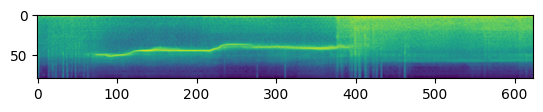

In [48]:
plt.imshow(res)